In [1]:
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import rasterio
import openeo

### Purpose

This notebook compares the shape of the clouds in three related steps of Sentinel-2 processing in EFAST.

1. The coarse (300m) cloud mask
2. Distance to cloud (ranges from 0 to infinity)
3. Distance to cloud score (ranges from 0 to 1).

The clouds are expected to have the same shape in all 3 products. They should all be on the same grid.

In the distance to cloud (DTC) product, the cloud mask should be exactly reproduced by those pixels that have a distance of 0.
In the distance to cloud score, because 1 is subtracted from the distance to cloud before computation, the cloud mask is reproduced with a border of exactly one pixel (4 neighbours) by those pixels that have a score of 0.

### Input data

In [3]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [4]:
spatial_extent_entire_granule = {
    "west": -15.936301,
    "south": 15.288158,
    "east": -14.909093,
    "north": 16.278762,
}
spatial_extent_smaller = {
    "west": -15.224,
    "south": 15.283,
    "east": -14.91,
    "north": 15.55,
}

spatial_extent = spatial_extent_smaller
temporal_extent = ["2023-09-11", "2023-09-12"]

In [5]:
UDF_CODE = """
from scipy.ndimage import distance_transform_edt
import numpy as np
import xarray as xr
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    if not array.any():
        return XarrayDataCube(xr.DataArray(np.full_like(array, np.inf), dims=["t", "y", "x"]))
    distance = distance_transform_edt(np.logical_not(array))
    return XarrayDataCube(xr.DataArray(distance, dims=["t", "y", "x"]))
"""

In [6]:
run_openeo = True
tile_factor = 10

dtc_udf = openeo.UDF(UDF_CODE)
image_size_pixels = None
border_pixels = None
max_distance_m = 6000
max_distance_pixels = max_distance_m / 300
overlap_length = int(max_distance_pixels * tile_factor)
patch_length = overlap_length * 2

In [7]:
openeo_results_base_path = Path("test_data")
openeo_results_base_path.mkdir(exist_ok=True)
#openeo_results_base_path = Path("/home/hannes/code/apex-efast-openeo/test_outputs/debugging_distance_to_cloud/")
s2_cloud_mask_coarse_path = openeo_results_base_path / "s2_cloud_mask_coarse.nc"
s2_dtc_path = openeo_results_base_path / "s2_distance_to_cloud.nc"
s2_distance_score_path = openeo_results_base_path / "s2_distance_score.nc"

In [8]:
scl = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=["SCL"],
).band("SCL")
cloud_mask = (scl == 0) | (scl == 3) | (scl > 7)
cloud_mask_mean = (cloud_mask * 1.0).resample_spatial(resolution=300, method="average")
cloud_mask_coarse = cloud_mask_mean >= 0.05

distance_to_cloud = cloud_mask_coarse.apply_neighborhood(
    dtc_udf,
    size=[
        {"dimension": "t", "value": "P1D"},
        {"dimension": "x", "value": patch_length, "unit": "px"},
        {"dimension": "y", "value": patch_length, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": overlap_length, "unit": "px"},
        {"dimension": "y", "value": overlap_length, "unit": "px"},
    ],
)
rescaled_dtc = (distance_to_cloud - 1) / max_distance_pixels
distance_score = rescaled_dtc.apply(lambda x: x.clip(min=0, max=1))
distance_score_with_band = distance_score.add_dimension("bands", label="distance_score", type="bands")


In [9]:
if run_openeo:
    distance_score_with_band.download(s2_distance_score_path)
    distance_to_cloud.download(s2_dtc_path)
    cloud_mask_coarse.download(s2_cloud_mask_coarse_path)
    

### Visualization

In [10]:
s2_cloud_mask_coarse = xr.open_dataset(s2_cloud_mask_coarse_path)["var"]
s2_dtc = xr.open_dataset(s2_dtc_path)["var"]
s2_distance_score = xr.open_dataset(s2_distance_score_path)["distance_score"]

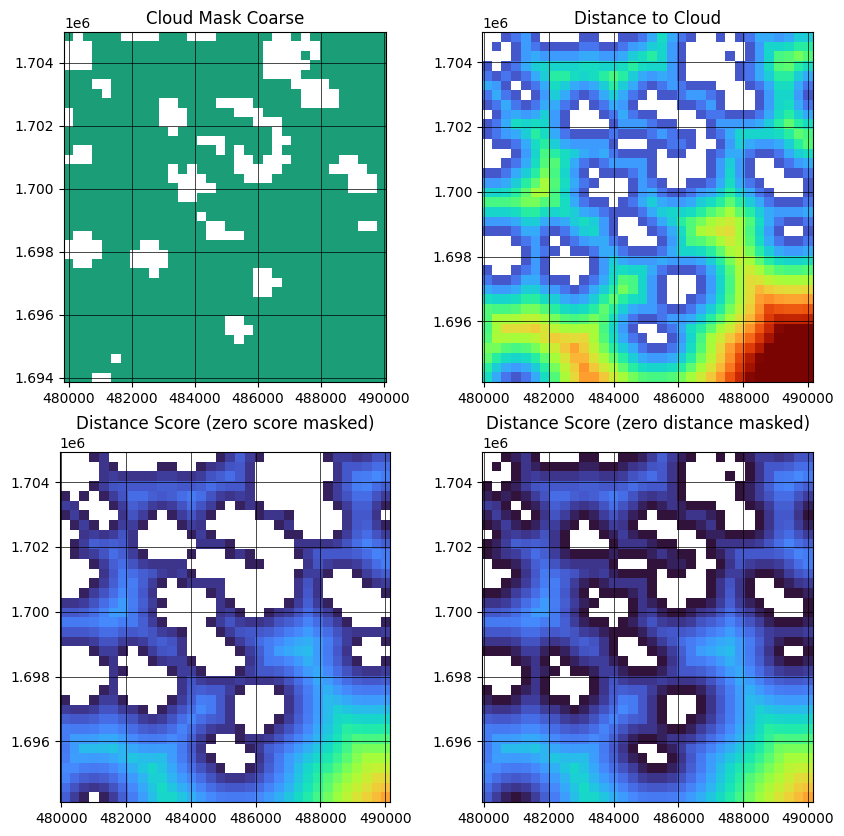

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

cloud_mask_coarse_ax, dtc_ax = axs[0, :] 
distance_score_ax, distance_score_masked_ax = axs[1, :]

selection = dict(
    x = slice(480000, 490000),
    y = slice(1.705 * 1e6, 1.694 * 1e6),
    t = "2023-09-11",
)

s2_cloud_mask_coarse_subset = s2_cloud_mask_coarse.sel(selection)
s2_dtc_subset = s2_dtc.sel(selection)
s2_distance_score_subset = s2_distance_score.sel(selection)

imshow_args = {
    "cmap": "turbo",
    "vmin": 0.00,
    "vmax": 1.0,
    "add_colorbar": False,
}

p_cm = s2_cloud_mask_coarse_subset.where(s2_cloud_mask_coarse_subset == 0).plot.imshow(
    ax=cloud_mask_coarse_ax,
    **(imshow_args | dict(vmin=0, vmax=8, cmap="Dark2")),
)

p_dtc = (s2_dtc_subset.where(s2_dtc_subset > 0)).plot.imshow(
    ax=dtc_ax,
    **(imshow_args | dict(vmin=0, vmax=10)),
)

s2_distance_score_subset.where(s2_distance_score_subset > 0).plot.imshow(
    ax=distance_score_ax,
    **imshow_args
)

s2_distance_score_subset.where(s2_dtc_subset > 0).plot.imshow(
    ax=distance_score_masked_ax,
    **imshow_args
)

cloud_mask_coarse_ax.set_title("Cloud Mask Coarse")
dtc_ax.set_title("Distance to Cloud")
distance_score_ax.set_title("Distance Score (zero score masked)")
distance_score_masked_ax.set_title("Distance Score (zero distance masked)")

for ax in axs.flatten():
    ax.set_aspect(1)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(True, color="black", linewidth=0.5)

### Observations

In the above figure, we can find a number of discrepancies from the expected output:

1. The grids to not match exactly. While the pixel size appears similar, the grid is not aligned to the remaining pixels
2. The cloud mask is not accurately reproduced in the distance to cloud
3. Distance to cloud accurately shows up in the disatance score

In [12]:
s2_cm_x_min = s2_cloud_mask_coarse.x.min().astype(int).item()
s2_cm_x_max = s2_cloud_mask_coarse.x.max().astype(int).item()
s2_dtc_x_min = s2_dtc.x.min().astype(int).item()
s2_dtc_x_max = s2_dtc.x.max().astype(int).item()
s2_cm_y_min = s2_cloud_mask_coarse.y.min().astype(int).item()

s2_dtc_y_min = s2_dtc.y.min().astype(int).item()
s2_cm_y_max = s2_cloud_mask_coarse.y.max().astype(int).item()
s2_dtc_y_max = s2_dtc.y.max().astype(int).item()

print("Value\t| Cloud mask\t| DTC\t\t| CM - DTC")
print("-" * 50)
print(f"x min\t| {s2_cm_x_min}\t| {s2_dtc_x_min}\t| {s2_cm_x_min - s2_dtc_x_min}")
print(f"x max\t| {s2_cm_x_max}\t| {s2_dtc_x_max}\t| {s2_cm_x_max - s2_dtc_x_max}")
print(f"y min\t| {s2_cm_y_min}\t| {s2_dtc_y_min}\t| {s2_cm_y_min - s2_dtc_y_min}")
print(f"y max\t| {s2_cm_y_max}\t| {s2_dtc_y_max}\t| {s2_cm_y_max - s2_dtc_y_max}")
#(s2_dtc.x.max().item(), s2_cloud_mask_coarse.x.max().item()), (s2_dtc.x.min().item(), s2_cloud_mask_coarse.x.min().item())

Value	| Cloud mask	| DTC		| CM - DTC
--------------------------------------------------
x min	| 476100	| 475900	| 200
x max	| 509700	| 509800	| -100
y min	| 1689510	| 1689770	| -260
y max	| 1719210	| 1719170	| 40


It also appears that the extends are not equal, and even have a different amount of pixels in x:

In [13]:
s2_cloud_mask_coarse.x.size, s2_dtc.x.size

(113, 114)

In [14]:
s2_cloud_mask_coarse.y.size, s2_dtc.y.size

(100, 99)